# pypylon performance demo

In [1]:
import pypylon.pylon as py
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
from IPython.display import display

In [2]:
tlf = py.TlFactory.GetInstance()

In [3]:
cam = py.InstantCamera(tlf.CreateFirstDevice())

In [4]:
cam.Open()

In [5]:
cam.DeviceModelName.Value

'acA1920-155uc'

In [6]:
cam.UserSetSelector = cam.UserSetDefault.Value
cam.UserSetLoad.Execute()

In [7]:
cam.Height = 2
cam.PixelFormat = "RGB8"

In [8]:
cam.ExposureTime = cam.ExposureTime.Min
cam.Gain = cam.Gain.Max

In [9]:
cam.ResultingFrameRate.Value

4901.9607843137255

In [10]:
def speed_test():
    cam.StartGrabbingMax(4901)
    while cam.IsGrabbing():
        with cam.RetrieveResult(1000) as res:
            assert res.GrabSucceeded()
            img = res.Array
    cam.StopGrabbing()

In [11]:
%%timeit
speed_test()

1.02 s ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


pypylon had no issues handling 4900 FPS

In [12]:
cam.Close()

## "linescan" capture

the inline capture can be stopped by using jupyter Break [] button.

It will display a fast inline linescan video display

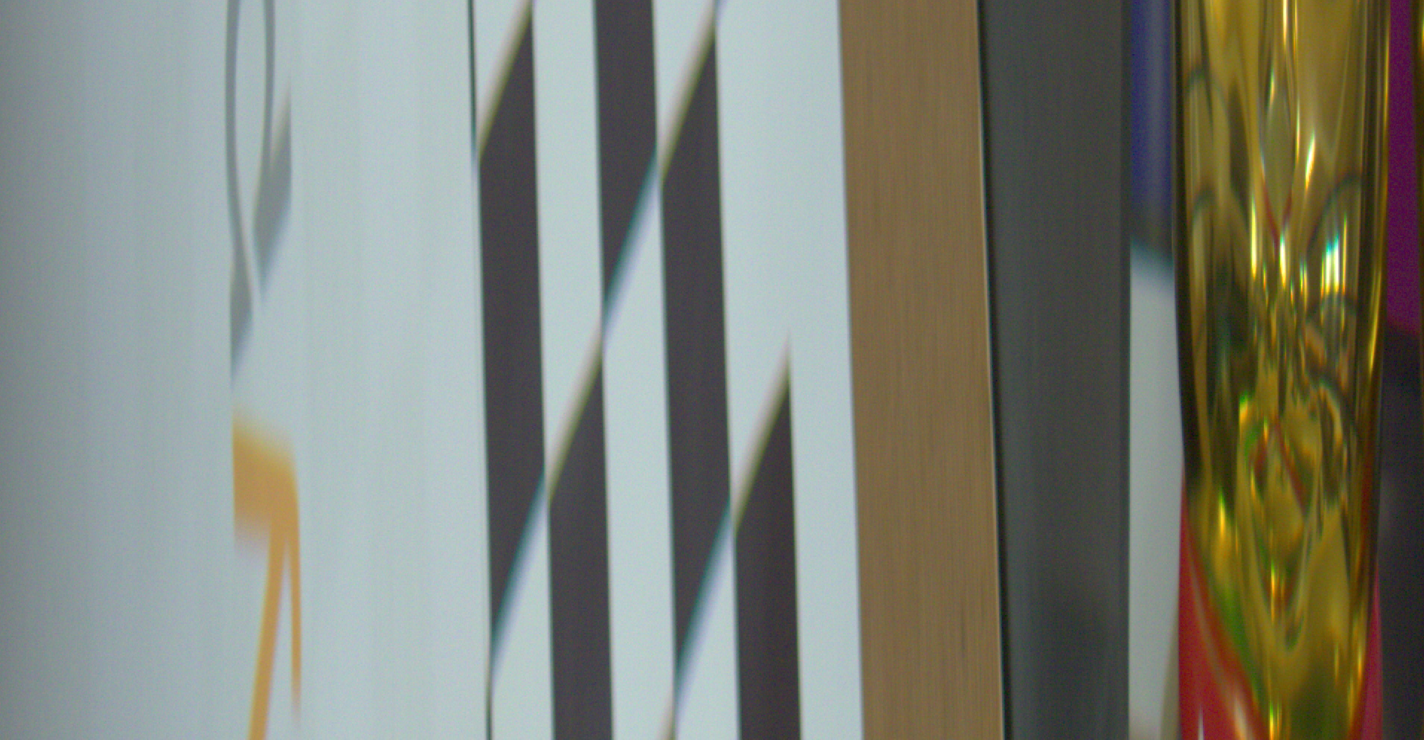

In [31]:
SCANLINE_HEIGHT = 2
VIRTUAL_FRAME_HEIGHT = 1000

tlf = py.TlFactory.GetInstance()

cam = py.InstantCamera(tlf.CreateFirstDevice())
cam.Open()

# setup center scan line
cam.Height = SCANLINE_HEIGHT
cam.Width = cam.Width.Max
cam.CenterX = True
cam.CenterY = True

# setup for
cam.PixelFormat = "BGR8"
cam.Gain = 20
cam.ExposureTime = 900
print("Resulting framerate:", cam.ResultingFrameRate.Value)

# setup jupyter video output 
# create display widget
imgbox = widgets.Image(format='jpg', height=1080//2, width=1920//2)
# display 
display(imgbox)
##

cam.StartGrabbing()

img = np.ones((VIRTUAL_FRAME_HEIGHT, cam.Width.Value,3), dtype=np.uint8)
missing_line = np.ones((SCANLINE_HEIGHT, cam.Width.Value,3), dtype=np.uint8)*255
image_idx = 0

try:
    while cam.IsGrabbing():
        for idx in range(VIRTUAL_FRAME_HEIGHT // SCANLINE_HEIGHT):
            with cam.RetrieveResult(2000) as result:
                if result.GrabSucceeded():
                    with result.GetArrayZeroCopy() as out_array:
                        img[idx * SCANLINE_HEIGHT:idx * SCANLINE_HEIGHT + SCANLINE_HEIGHT] = out_array
                else:
                    img[idx * SCANLINE_HEIGHT:idx * SCANLINE_HEIGHT + SCANLINE_HEIGHT] = missing_line


        imgbox.value = cv2.imencode('.jpg', img)[1].tobytes()

        image_idx += 1
except KeyboardInterrupt:
    print( "break grab loop")
    pass

# When everything done, release the capture
cam.StopGrabbing()

cam.Close()

Resulting framerate: 1042.752867570386


Image(value=b'', format='jpg', height='540', width='960')

break grab loop


In [ ]:
cam.Close()